In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sklearn
from sklearn import datasets
import scipy
import math
import cv2

In [2]:
def plot_images(images, rows, cols, titles=None, figsize=(20,7)):

    fig, axarr = plt.subplots(rows, cols, figsize=figsize)
    axarr = np.array(axarr).reshape(-1) 

    for i, ax in enumerate(axarr):
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')
        if titles:  
            ax.set_title(titles[i])

    plt.tight_layout()
    plt.show()

#All rights resevred to n0acar (github username)
def plot_portraits(images, n_row, n_col, titles, h, w,):
    plt.figure(figsize=(2.2 * n_col, 2.2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].real.reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())

# Capturing the image
###### (Not related to class content, skip if not interested.)

In [3]:
#Opens the camera
camera = cv2.VideoCapture(0)

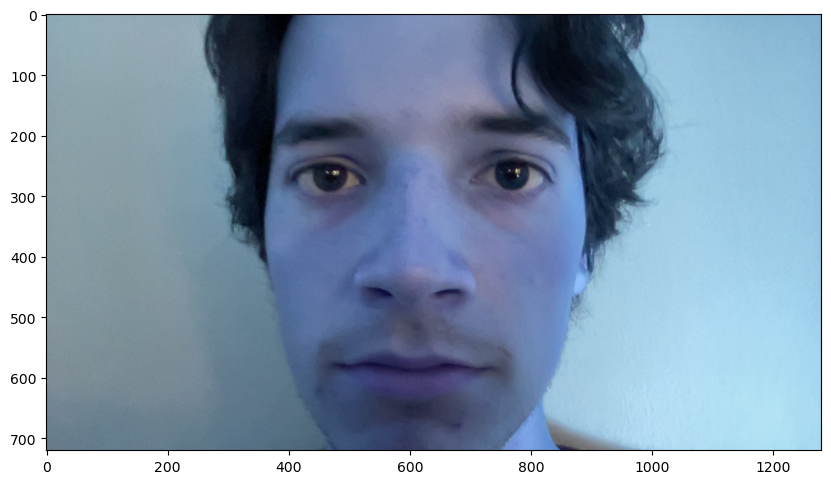

In [4]:
#Taking a picture of you
ret, frame = camera.read()
RBGFace = np.array(frame)
plt.figure(figsize=(10,10))
plt.imshow(frame)
plt.show()
camera.release()

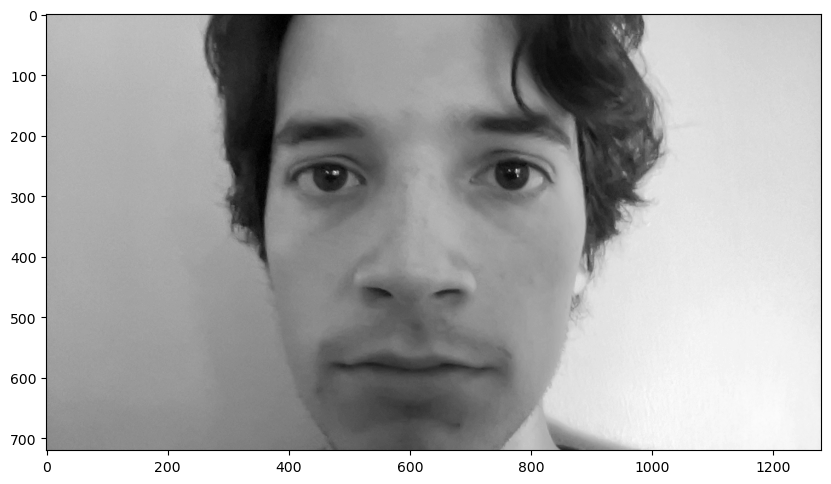

In [5]:
#Converting to grayscale and plotting new image:
gsFace = cv2.cvtColor(RBGFace, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(10,10))
plt.imshow(gsFace, cmap = 'gray')

In [6]:
#Next, we convert this image into a 64x64 pixel array:
height, width = gsFace.shape

#Cropping the sides:
croppedFace = gsFace[0 : height, (width-height)//2 : width - (width-height)//2]
#Note that this assumes width > height. If your camera produces an image with height > width,
#Comment out the last line and use this instead:
# croppedFace = gsFace[(height-width)//2 : height - (height-width)//2, 0:width]

#Scaling it down (taking the average of neighboring pixels):
scaledFace = np.zeros(shape=(64,64))
div = height//64
k, q = 0, 0

for i in range (64):
    for j in range (64):
        scaledFace[i,j] = np.mean(croppedFace[k : k + div, q : q + div])
        q += div
    k += div
    q = 0

#As a last step, we normalize the array to match the dataset we'll use:
scaledFaceNormalized = (scaledFace - np.min(scaledFace))/np.ptp(scaledFace)

#Note that this approach is very rudimentary, we just crop the sides until the image is square and scale it down.

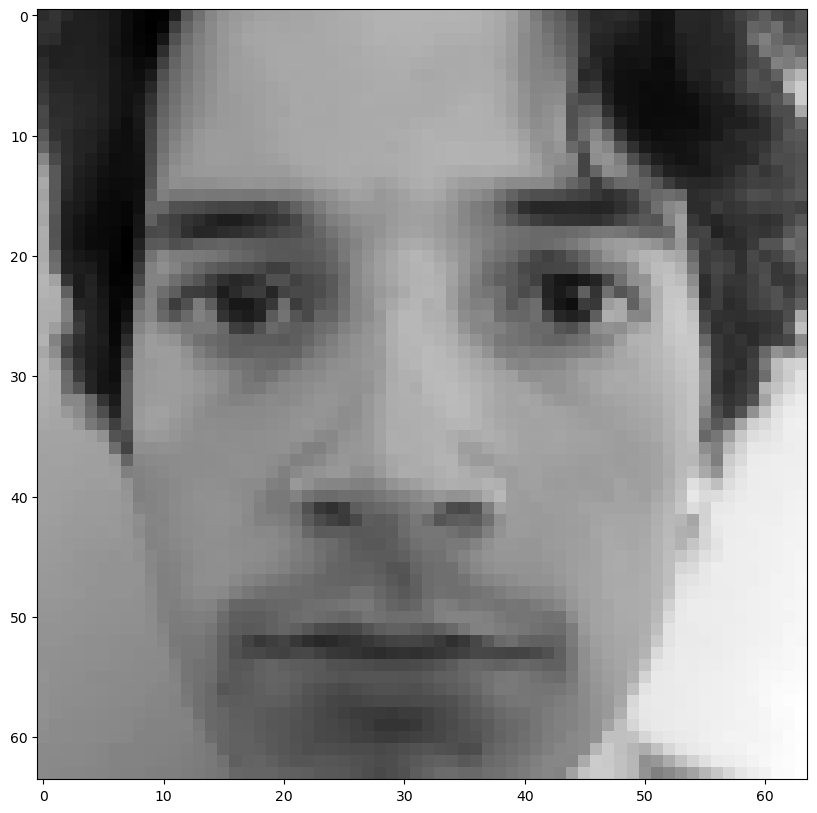

In [7]:
#We now have an appropriate array to work with!
plt.figure(figsize=(10,10))
plt.imshow(scaledFaceNormalized, cmap = 'gray')

# Onto SVD!

In [8]:
#Getting the dataset we'll use to perform SVD:
olivetti = sklearn.datasets.fetch_olivetti_faces()
faces = olivetti['data']

'faces' is a 400x4096 array, where we have 400 instances of 64x64 images of faces that are flattened and stored as rows

We'll call the `faces` dataset $F$. We want to perform the following decomposition:

$$F = U \Sigma V^T$$

We can do this with a numpy function, or we can do it manually.

We know the columns of $U$ are the unit eigenvectors of $FF^T$\
We know the columns of $V$ are the unit eigenvectors of $F^TF$
We know $\Sigma$ is a 'pseudo-diagonal' matrix of the singular values of $FF^T$ and $F^TF$\
We also know we need to sort the singular values of $\Sigma$ accordingly with the eigenvectors in $U$ and $V$.

With this in mind, we can find these values:

### SVD with numpy:

In [9]:
#The numpy function returns a list of the singular values, so we need to put them into S:
U, s, VT = np.linalg.svd(faces, compute_uv=True)
S = np.zeros(shape=(400,4096))
for i in range(400):
    S[i,i] = s[i]

Sanity check: Let's reconstruct the matrix $F$ using the formula above and the values returned by numpy, and check that the resulting images match those of the original dataset:

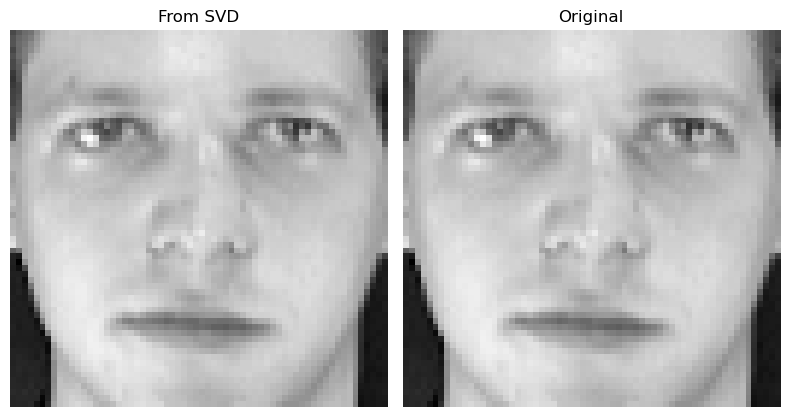

In [10]:
SVDTest = U@S@VT

face_0_SVD = SVDTest[0].reshape(64,64)
face_0_original = faces[0].reshape(64,64)

plot_images([face_0_SVD, face_0_original], 1, 2, titles=['From SVD', 'Original'], figsize=(8,8))

math doesn't lie!

#### What's happening?


Recall that SVD can be expressed as a sum of rank 1 matrices:

$A = \sigma_1 u_1 v_1^T + \sigma_2 u_2 v_2^T + \cdots + \sigma_r u_r v_r^T+ \cdots + \sigma_n u_n v_n^T$

As such, we can cut this sum at any one of the terms, which is exactly what the demonstration above does. To have a bit more of a conceptual understanding of what is going on, we can look at what the actual faces look like when we stop the sum at a given term.

The rank of 'faces' is 400. Let's look at what happens when we add more terms to the sum of rank 1 matrices, getting closer to the full rank:

In [11]:
SVDfaces = []

for i in range (0, 400, 50):
    SVDfaces.append((U[:, 0:i]@S[0:i, 0:i]@VT[0:i, :])[0].reshape(64,64))

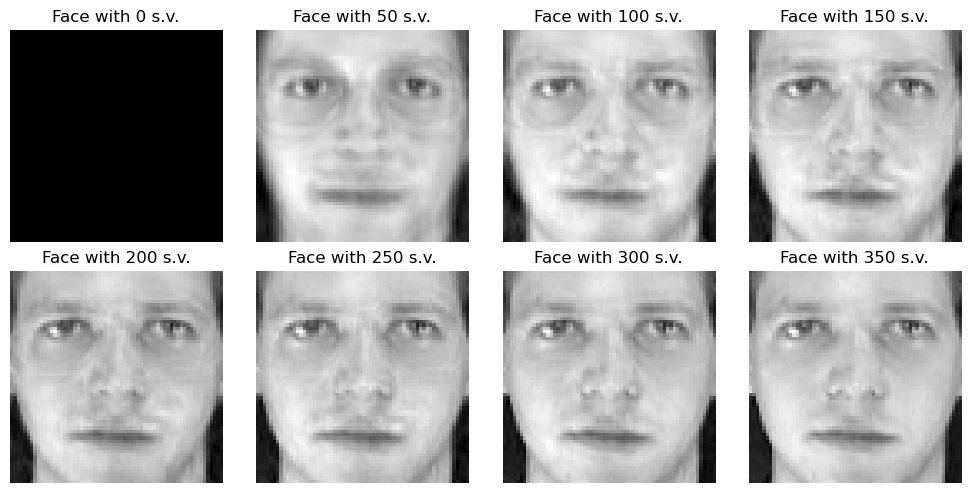

In [12]:
titles = ["Face with %d s.v." %i for i in range(0, 400, 50)]
plot_images(SVDfaces, 2, 4, titles=titles, figsize=(10,5))

As you can see, the image already looks somewhat recognizable with only 50 singular values and almost identical to the original image with 200! This shows that indeed, the 'importance' os singular values is not uniformly distributed, an with just a few important descriptors of our data, we can capture (with high fidelity) the original dataset.

If you're wondering how this translates into the real world, with some simple statistics we can turn SVD into an even more useful tool...

## Data Science and Rudimentary facial reconstruction and recognition (PCA)

We will now slightly adjust the original demonstration and our goal will be altered as well. Our objective is now to use SVD for dimensionality reduction on a dataset and to perform a very rudimentary application of facial reconstruction and recognition.

Most (if not all) of the work ahead comes from Matthew Turk's and Alex Pentland's *'Eigenfaces for Recognition'*, a paper I highly recommend you read!!

### The idea:

By deconstructing our dataset of faces into its intrinsic components, which we'll later call 'eigenfaces', we can express each face as a collection of 'weights', or, coefficients of a linear transformation we get from projecting said image to a lower dimensional 'facespace'.

This in turn allows us to project new images to this space, and try to find the closest image to it present in the dataset, making a prediciton of what face we have.

### In practice:

We start by again collecting the 'faces' dataset (this step is not necessary since we already have this in scope, but keeps things clear).

In [13]:
olivetti = sklearn.datasets.fetch_olivetti_faces()
faces = olivetti['data']

Next, we need to normalize the dataset, meaning, we compute the 'average' instance, in this case, a face and subtract it from the matrix. The reason we do this is so we can apply some statistical knowledge and tools later.

In [14]:
avgFace = np.average(faces, axis=0)

Let's take a look at what the 'average' face looks like in this dataset!

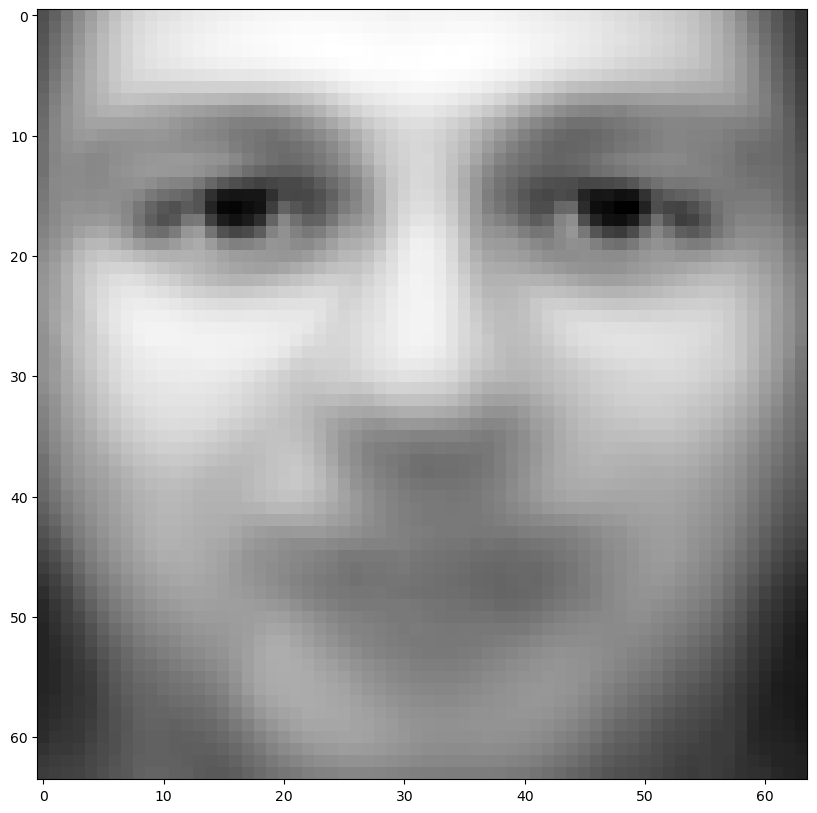

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(avgFace.reshape(64,64), cmap='gray')

We now subtract it from all faces in the dataset:

In [16]:
normFaces = faces - avgFace

Let's take a look at what a `normalized' face looks like:

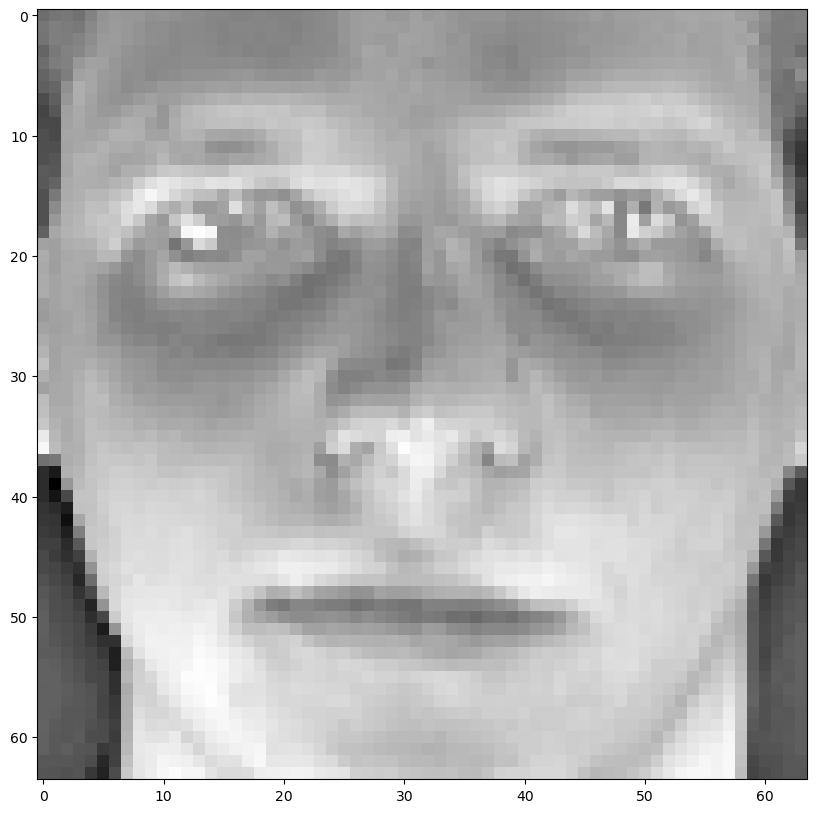

In [17]:
plt.figure(figsize=(10,10))
plt.imshow(normFaces[0].reshape(64,64), cmap='gray')

We can now very simply compute the covariance matrix of the dataset. Let's call this matrix $C$, where $C_{ij} = cov(\text{faces[i]}, \text{faces[j]}) = \frac{1}{4096} \sum_{k=1}^{4096}\text{(faces[i,k]- average faces[i])(faces[j,k]- average faces[j])}$. Note however that since we normalized the dataset, we can simply express $C$ as $F^TF$, convenient!

We now perform SVD on the covariance matrix, $F^TF$:

In [18]:
Cov = normFaces.T@normFaces
eigvals, eigvecs = np.linalg.eig(Cov)

This time we're doing SVD by hand (note how much slower this is!), in fact, what we're about to do is known as PCA, and stands for Principal Component Analysis. 

The next step is to sort the eigenvectors of the covariance matrix by their corresponding eigenvalues in descending order:

In [19]:
order = np.argsort(eigvals)[::-1]
sorted_eigvals = eigvals[order]
sorted_eigvecs = eigvecs[:, order]

Recall that the principal components are the $v_i$'s. Let's look at what they actually look like:

In [20]:
eigvecs.shape

(4096, 4096)

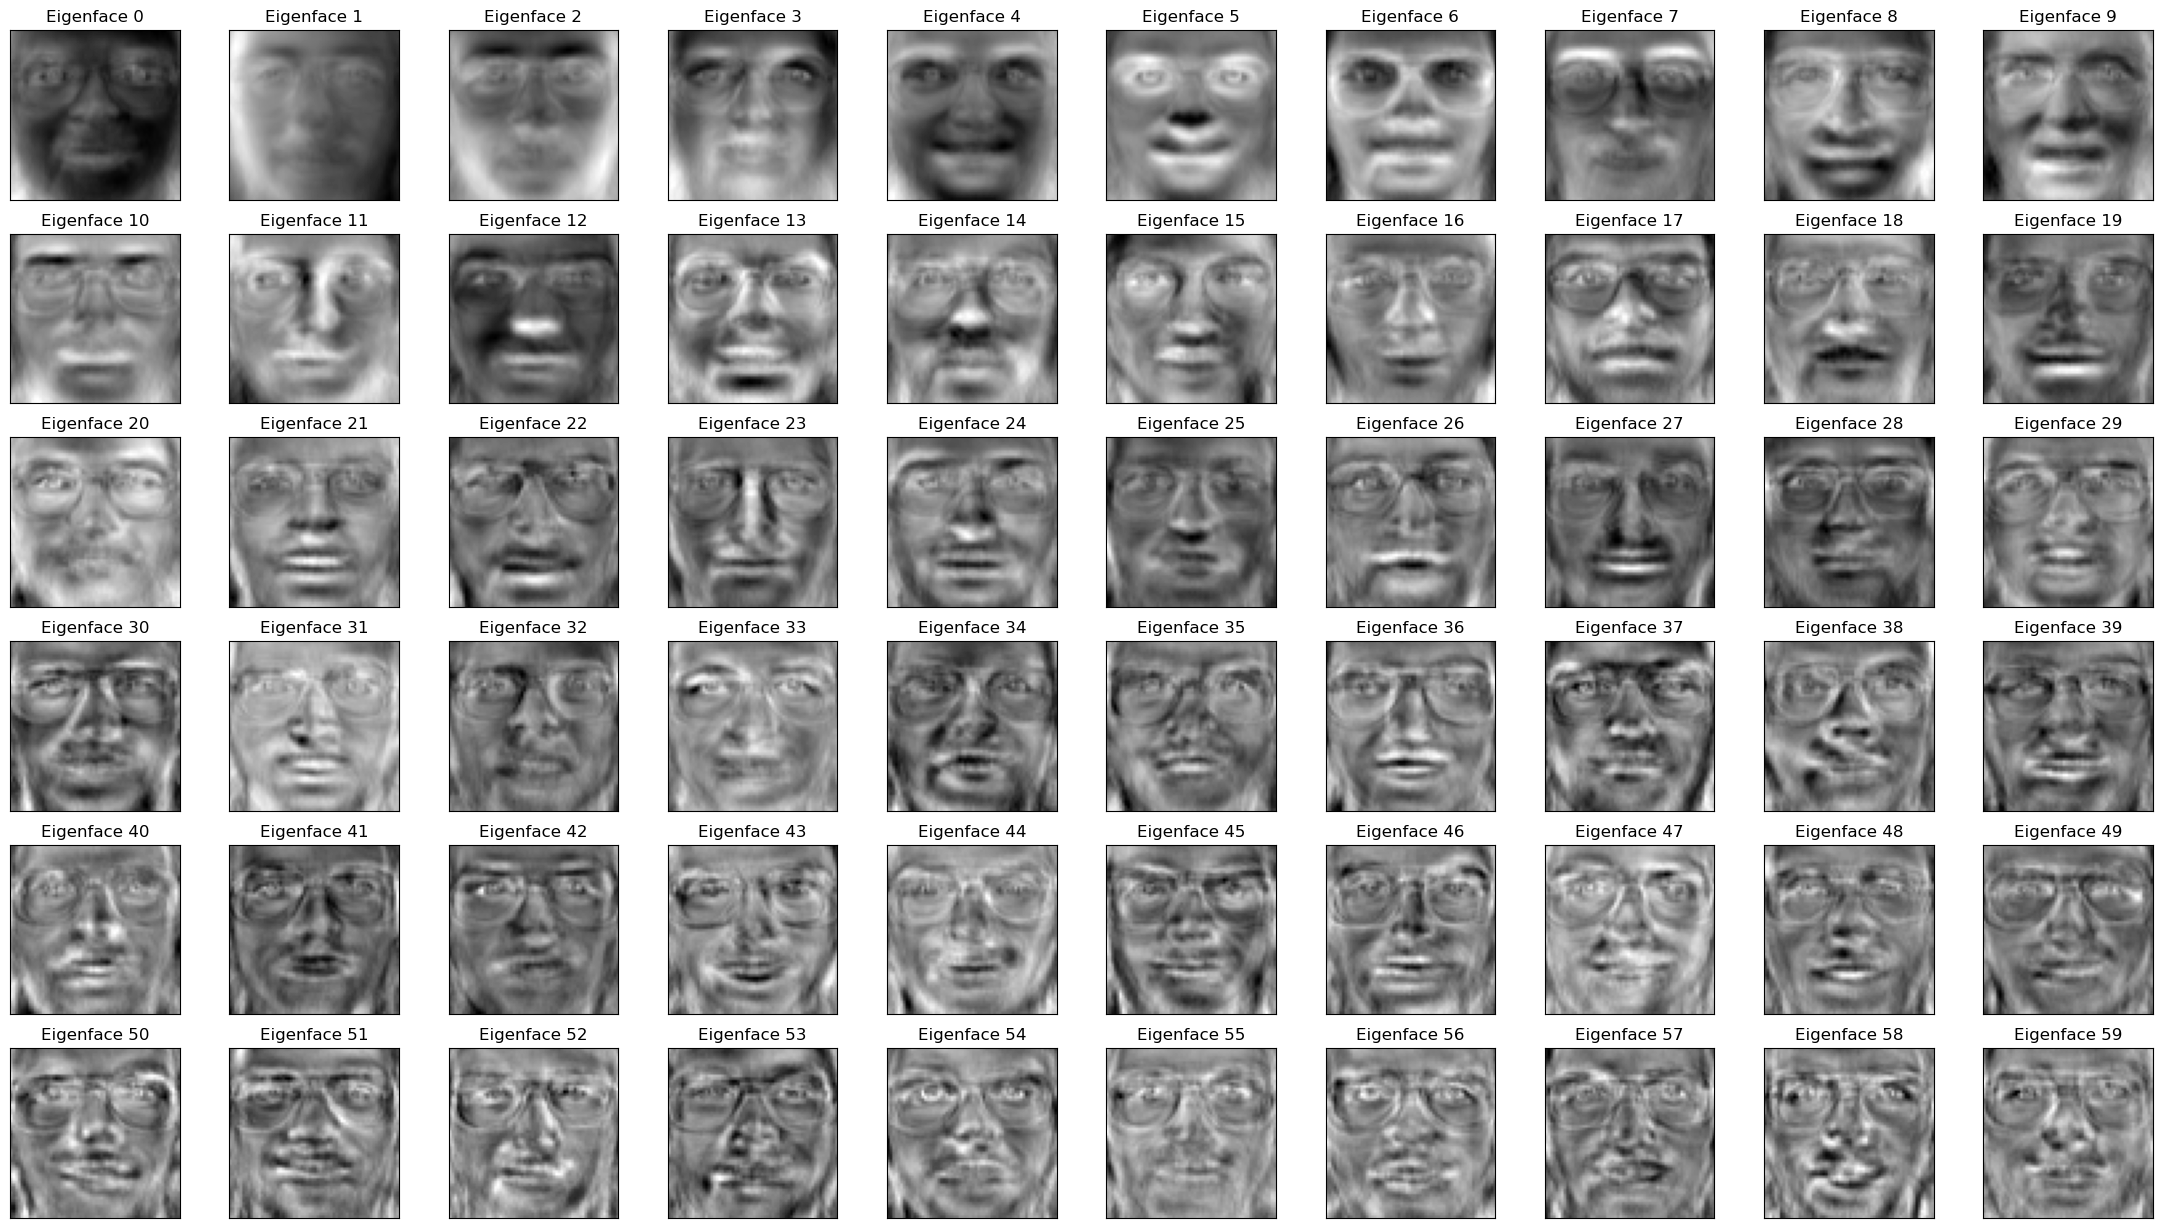

In [23]:
eigtitles = ["Eigenface %d" %i for i in range(4096)]
plot_portraits(sorted_eigvecs.real.T, 6, 10, eigtitles, 64, 64)

This gives a very interesting observation as to what is going on when we do PCA for a dataset. We are expressing the instances of the original dataset as linear combinations of the $v_i$'s, in our case, the eigenfaces:

$$\text{face} = f = (f^T v_1) v_1 +\cdots + (f^T v_n) v_n$$

That means that we can find out how an image in the `faces` dataset breaks down into eigenfaces. We can do this by projecting an image into the subspace spanned by the eigenfaces, to get the coefficients in our linear combination. We do so by combining the eigenfaces into a single matrix, $E$, who's rows are the eigenfaces. Then, 

$$Ef = (f^T v_1,\ldots, f^T v_n)$$

is a vector of the coefficients used in the linear combination.

Let's do another sanity check, this time explicitly extracting all the coefficients and multiplying each one by its corresponding eigenface:

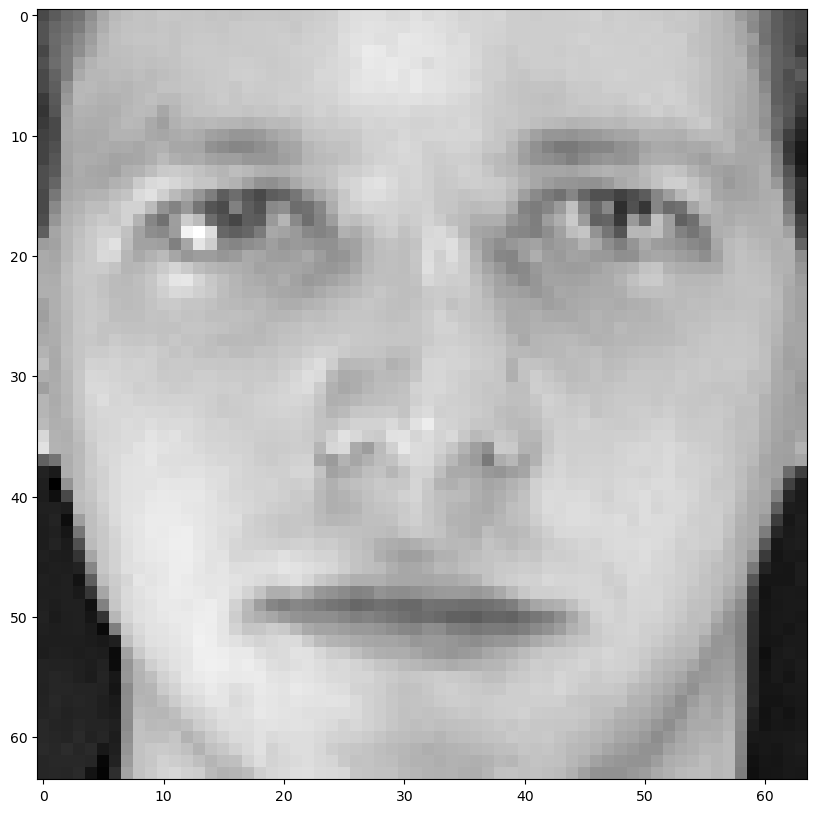

In [24]:
E = sorted_eigvecs.T
coeffs0 = E@faces[0]
testReconstruction = np.zeros(shape=(4096))

for i in range(4096):
    testReconstruction += coeffs0[i]*E[i]

plt.figure(figsize=(10,10))
plt.imshow(testReconstruction.reshape(64,64), cmap='gray')

We have seen before that we can cut this sum at any point, and indeed, if we stop adding terms after 200 principal components, for example, we get

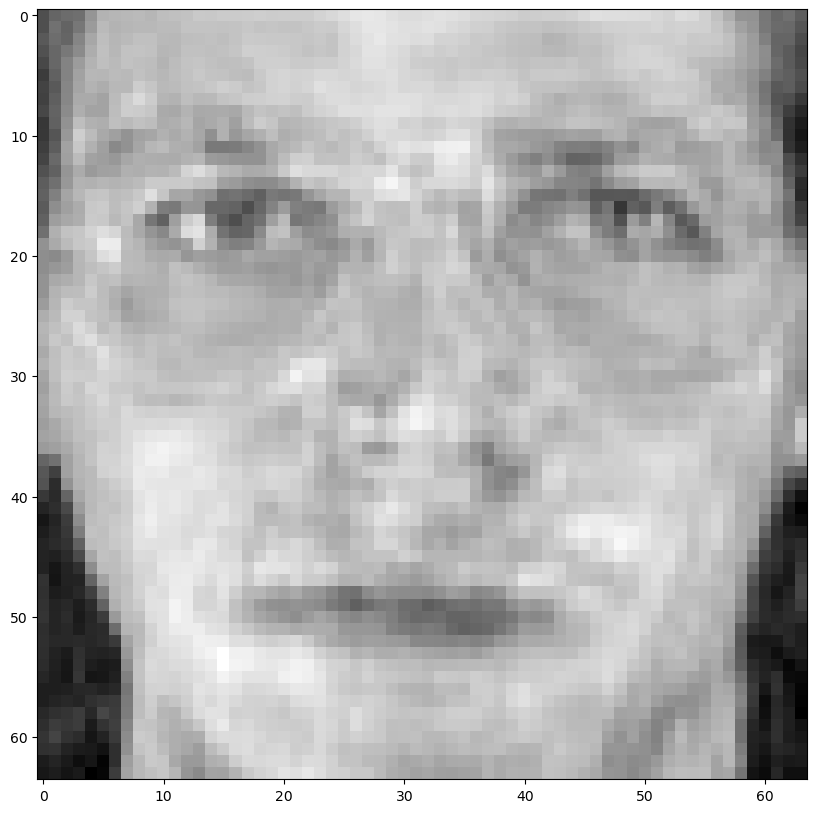

In [25]:
testReconstruction_quarter = np.zeros(shape=(4096))

for i in range(200):
    testReconstruction_quarter += coeffs0[i]*E[i]

plt.figure(figsize=(10,10))
plt.imshow(testReconstruction_quarter.reshape(64,64), cmap='gray')

Now, nothing is stopping us from using a new, completely different image! This is where we can really begin to have some fun with image reconstruction. Let's project our own picture onto the 'eigenfaces' and see what we get!

In [26]:
myCoeffs = E@scaledFaceNormalized.reshape(4096)

Let's take a look...

In [27]:
myCoeffs

array([-2.99472993e+01,  3.91284645e-03,  4.37232384e+00, ...,
       -2.08224232e-02, -1.09462615e-01,  2.91761728e-02])

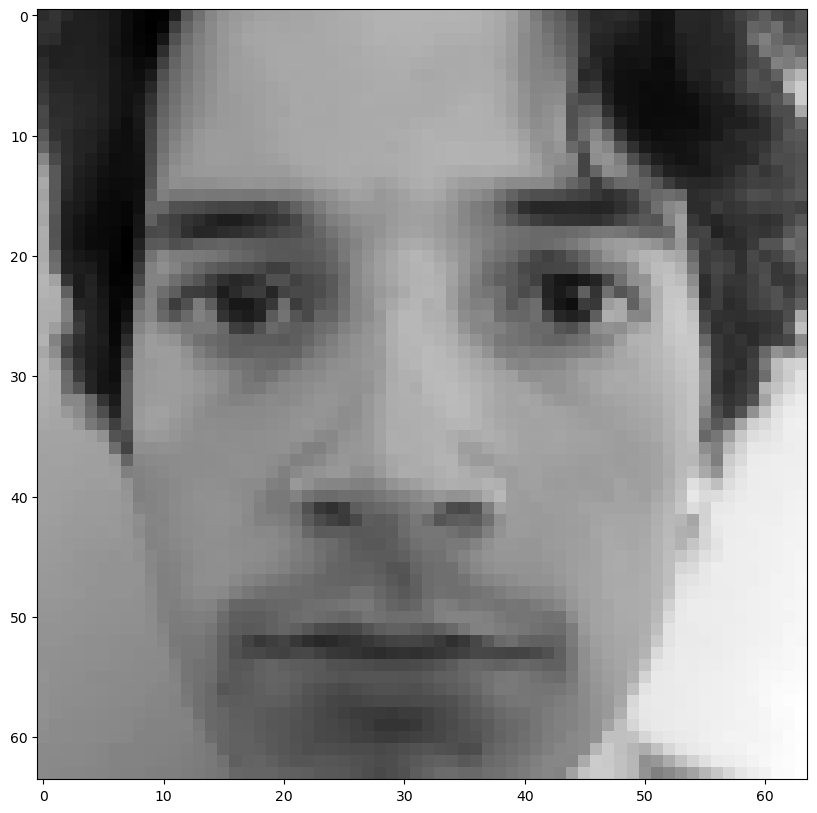

In [30]:
myReconstruction = np.zeros(4096)

#We can project the original image with simpler matrix multiplications, but let's be explicit and see exactly what we're doing:

for i in range(4096):
    myReconstruction += myCoeffs[i]*E[i]

plt.figure(figsize=(10,10))
plt.imshow(myReconstruction.reshape(64,64), cmap='gray')

This is pretty amazing!!! In fact the reconstruction error of this reconstructed image to the original is only

In [32]:
np.linalg.norm(myReconstruction-scaledFaceNormalized.flatten())

2.343637723022997e-06

This number is tiny! Keep in mind that the reconstruction is just a projection of my face onto the face space!

Lets look at what happens when we don't use all the components though:

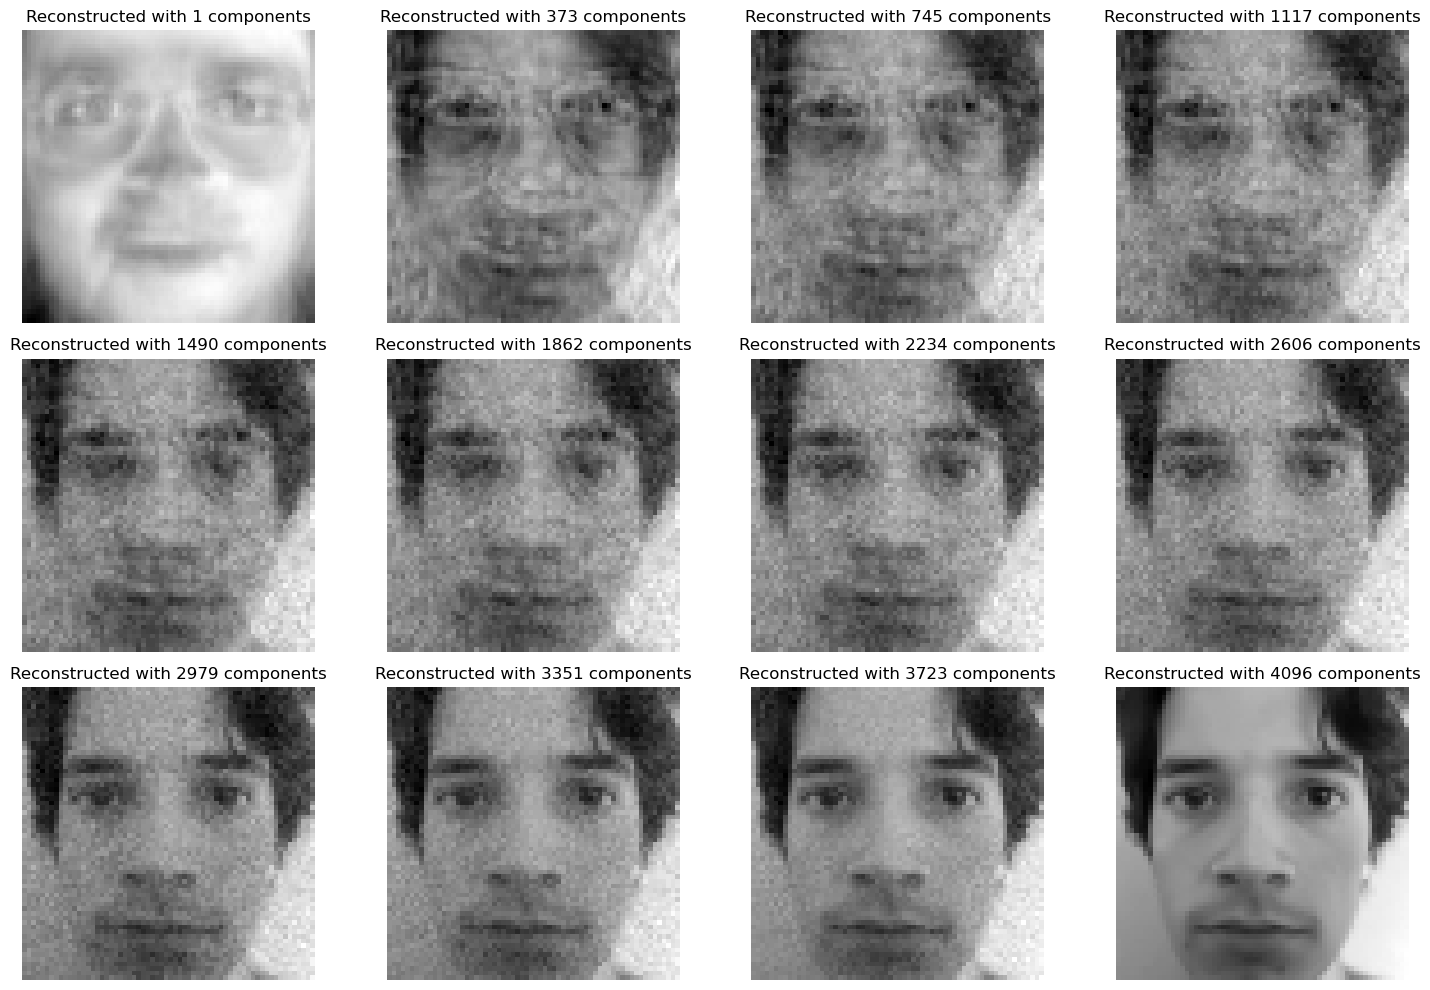

In [38]:
components = np.linspace(1, 4096, 12, dtype=int)
reconstructed_images = []

for comp in components:
    reconstruction = E[:comp].T @ myCoeffs[:comp] #more efficient matrix multiplication
    reconstructed_images.append(reconstruction.reshape(64,64))

titles = ["Reconstructed with %d components" % comp for comp in components]
plot_images(reconstructed_images, 3, 4, titles=titles, figsize=(15,10))

We can see that it takes a high number of components to get a good representation of the original image.

We can perform rudimentary detection by determining the vector in the dataset that minimizes the magnitude of the difference of said vector and the projected image:

$$||v-\text{projected}f||$$

We can do this by just looking at the coefficients and making our lives easier. We first need to colloect the coefficients on our dataset:

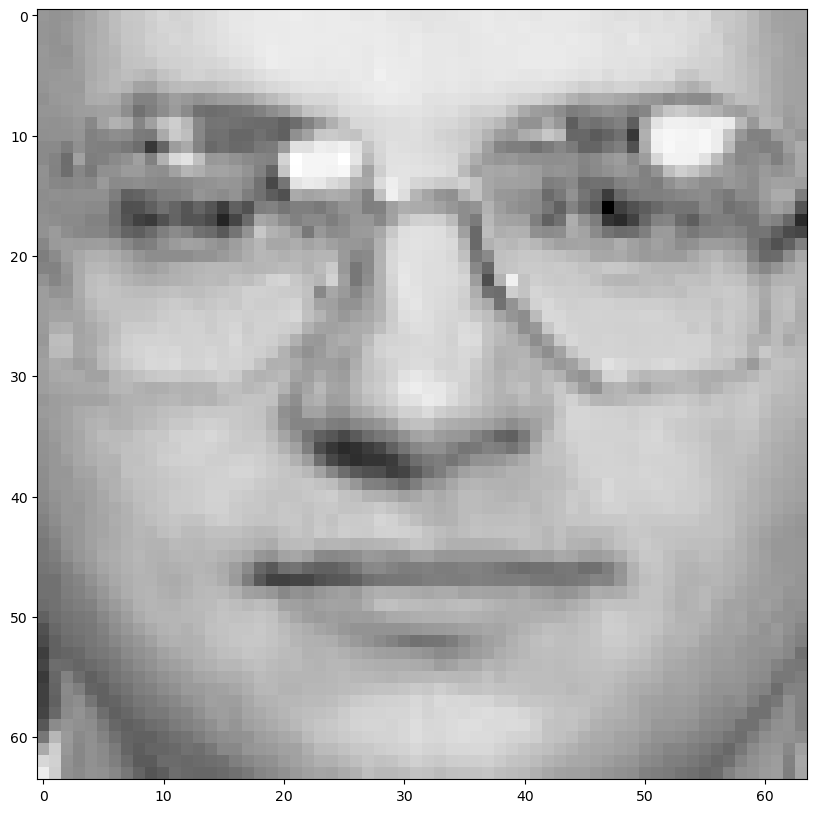

In [36]:
coeffsMatrix = E@normFaces.T

# Now, we find the vector in the dataset that minimizes the magnitude of the difference
# between itself and the projected image

distances = np.linalg.norm(coeffsMatrix - np.reshape(myCoeffs, (4096,1)), axis=0)
closestFaceIndex = np.argmin(distances)

# Let's see the closest face in the dataset to our image

plt.figure(figsize=(10,10))
plt.imshow(faces[closestFaceIndex].reshape(64,64), cmap='gray')

Well, we can see that this is not very good, but keep in mind that this dataset is **tiny** compared to what is usually used in the real world. It is also worth noting that the 400 faces in it are from only 40 people (mostly white men), so the representativeness isn't very good. Yet, and especially with this in mind, it is amazing to see just how powerful PCA is. We were able to reconstruct a face not present in the original dataset fairly decently (all things considered) with just a handful of principal components.

I hope you have enjoyed this demo and that it sets you on the voyage of discovery amongst the many more advanced algorithms in data science! I also hope it has helped to develop some intuition for this topic, and for 21-241 students, please contact me at fmautner@andrew.cmu.edu if you have any questions or suggestions.